# Homework 4: Conversation Modeling and decoding

# Part 1 Modeling

## 1.1 Attention visulization

In [0]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch

RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t') # \t for tab
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text): # list of word to index
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids): # list of index to word
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [0]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [0]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t) # create a new tensor with same dtype and device as the old
                                         # size of tensor is from outer to inner
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths # list of padded tensors (2D), list of number of tokens except pad tokens

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packing
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [59]:
chat_dict = ChatDictionary('./drive/My Drive/dict')
train_dataset = ChatDataset('./drive/My Drive/train.jsonl', chat_dict)
valid_dataset = ChatDataset('./drive/My Drive/valid.jsonl', chat_dict, 'valid')

100%|██████████| 7801/7801 [00:00<00:00, 8943.13it/s]


In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=64)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=64)
valid_loader_heatmap = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=1)

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx) 

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
      
        return output, hidden, attention_mask # h_t for each t, h_t for last t, _

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states): # decoder_input, encoder_hidden, encoder_states
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden) 
                                                                                               
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)
     
        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [62]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if current_device == 'cuda':
    model_pt = torch.load('./drive/My Drive/chat_model_best_22.pt')
else:
    model_pt = torch.load('./drive/My Drive/chat_model_best_22.pt', map_location=torch.device('cpu'))
opts = model_pt['opts']
    
model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=18760, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
  )
)

In [0]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy
%matplotlib inline


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize = (50,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words.split(' '))

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    

    plt.show()
      

In [64]:
from random import randint
sample_index = []
for i in range(5):
    sample_index.append(randint(0, 1000))

sample_index

[399, 167, 412, 756, 868]

In [0]:
#sample_index = [50, 100, 150, 200, 250]
inputs, targets, attns = [], [], []

for i, batch in enumerate(valid_loader_heatmap):
    if i in sample_index:
        model.eval()
        text_vecs = batch['text_vecs'].to('cuda')
        inputs.append(chat_dict.v2t(text_vecs[0].tolist()))
        target_vecs = batch['target_vecs'].to('cuda')
        targets.append(chat_dict.v2t(target_vecs[0].tolist()))
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        attns.append([np.array(i[0].tolist()) for i in attn_w_log])
    if i > max(sample_index):
        break 

### You present here:

In [0]:
# this is some example attention map here, 
# *make sure you add text tokens on the axes to make it readable!*

Input:
your persona : i work in it and have been at the same company for 15 years . 
 your persona : i own a house in florida . 
 your persona : i enjoy american sports . 
 your persona : i am a male . 
 your persona : i have a children and a dogs . 
 hey there how is it going ?
Target:
hello . all is moving great . and you ? __end__


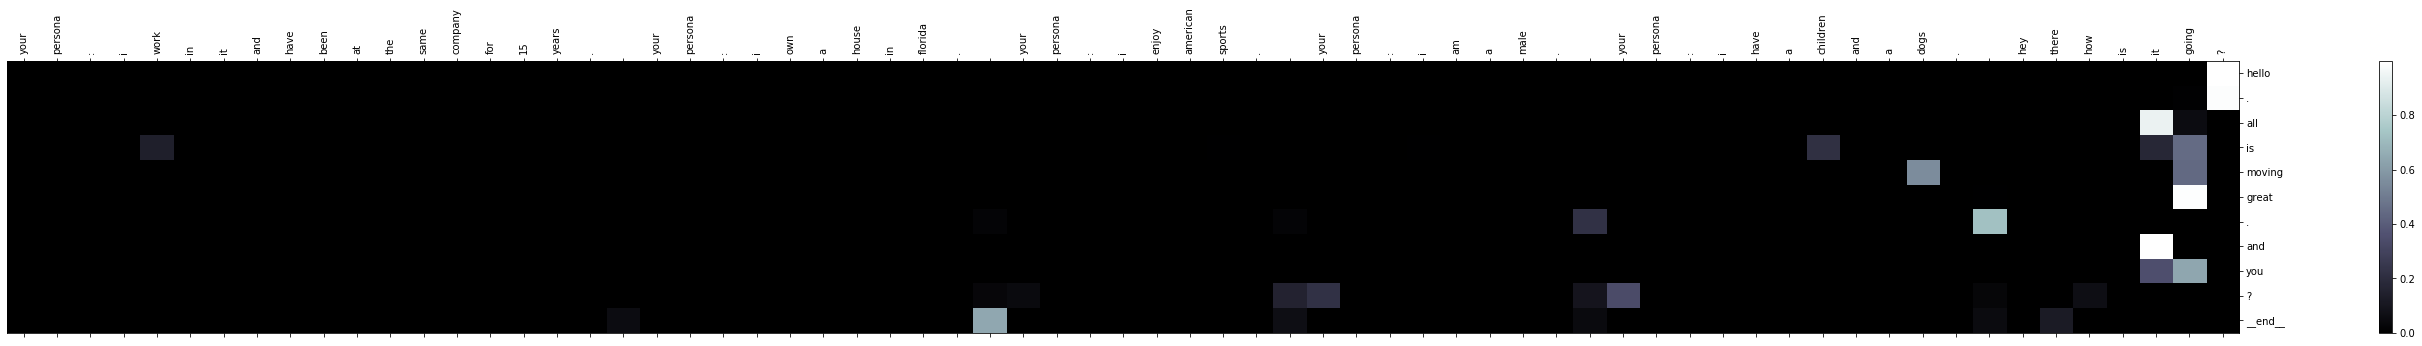

Input:
your persona : two dogs live with me . 
 your persona : i ' ve short hair . 
 your persona : i like doing the treadmill and __unk__ machine . 
 your persona : i go to the gym regularly . 
 hello , my name is leon . i am a audio engineer . how are you ? 
 hello , leon . my dogs and i are doing well . 
 that is good to hear ! i ' ve been better , my girlfriend just left me . 
 oh no . i go to the gym a lot . the treadmill keeps my mind off things . 
 i tend to stick indoors but maybe the gym will help , thanks . 
 you are most welcome . the __unk__ machine is nice too . 
 that ' s a full body work out right there . do you live in california ? 
 sadly , no . my dogs and i are in ohio . 
 i think i need to move . my studio is __unk__ after the decline of the market . 
 oh no . i ' m moving soon as well . due to personal reasons . 
 well i hope your reasons work themselves out . what kind of dogs do you have ?
Target:
i ' ve a springer spaniel and a lab . do you have pets ? __end__


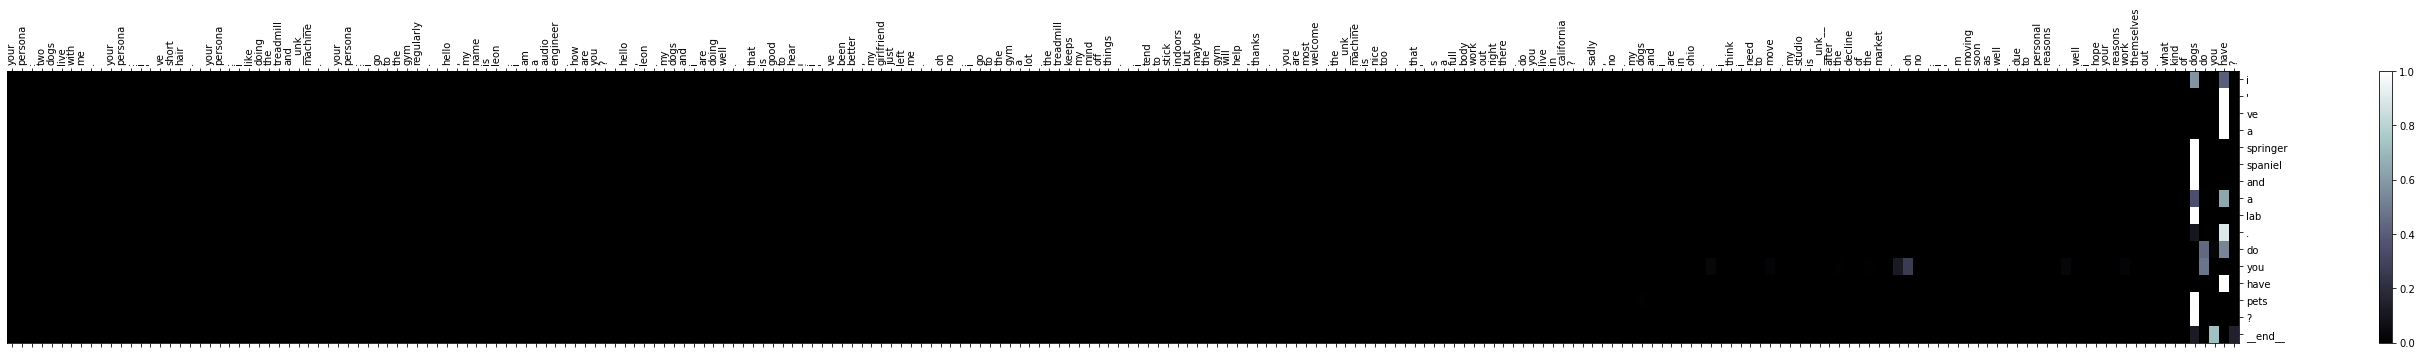

Input:
your persona : i ' m 13 years old . 
 your persona : i ride the bus to school . 
 your persona : my brother is older than me . 
 your persona : i hate math class . 
 your persona : i ' m on the soccer team . 
 how are you doing today 
 great thanks . what are you doing ? 
 i am playing my favorite game 
 hat game ? i love games as well , being 13 and all . 
 no it is on xbox 
 i ' ve an xbox too . my older brother never will let me play though . 
 that isn ' t very nice
Target:
no , and i cry about it whilst i am on the bus for school . very sad . __end__


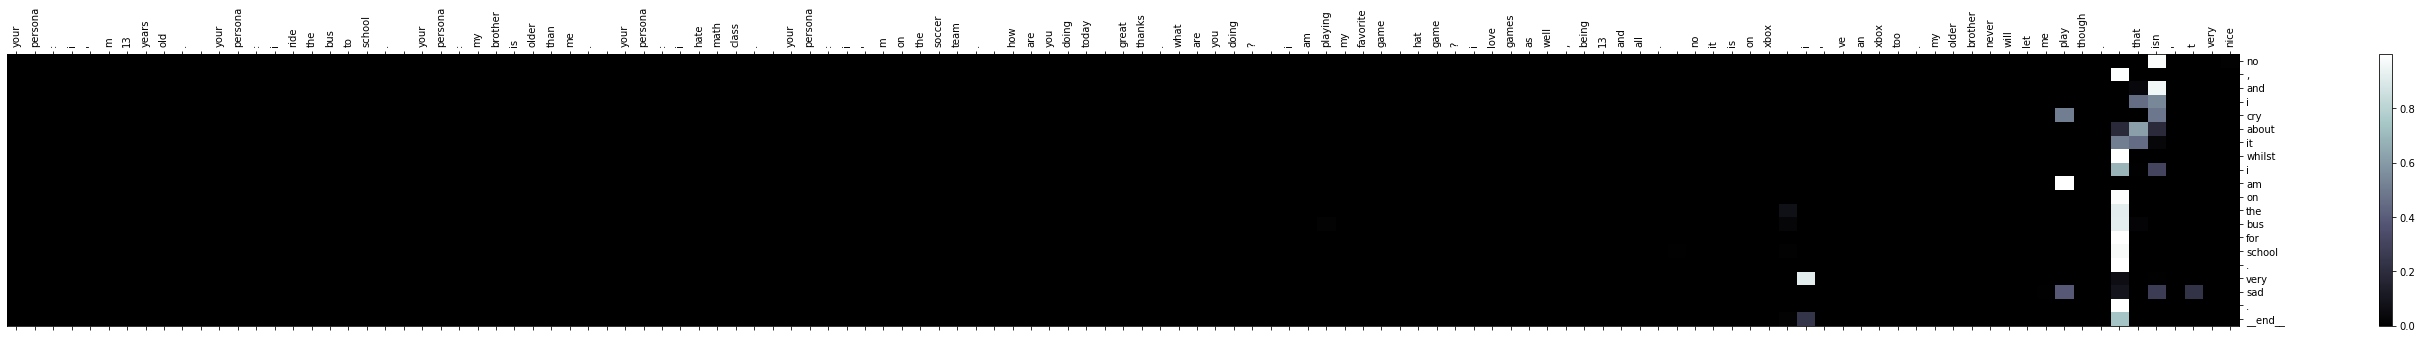

Input:
your persona : i feel like i might live forever . 
 your persona : i am 100 years old . 
 your persona : i love to drink wine and dance in the moonlight . 
 your persona : i remember when nobody had a television . 
 your persona : i am very strong for my age . 
 hi , tracy here . i ' m __unk__ , waitress in the daytime and race motorbikes at night . 
 hi there . i ' m __unk__ who could probably live forever 
 wow ! i ' ve olive skin and doe brown eyes . you believe in god ? 
 yes . and i ' ve lived for 100 years ! 
 great ! my helmet is red and my __unk__ is blue and my eyes are brown . 
 well . i think my __unk__ is due to wine drinking and dancing under the moonlight 
 cool ! i hope you live another 100 years . is dancing your work ? 
 no , but i am so old , i remember the time before a television . 
 wow ! are you strong like me . i love to drink red wine under the moon . 
 yes ! i ' m very strong for a 100 year old ! 
 great ! i ' ll be a 101 tomorrow . you like radio progra

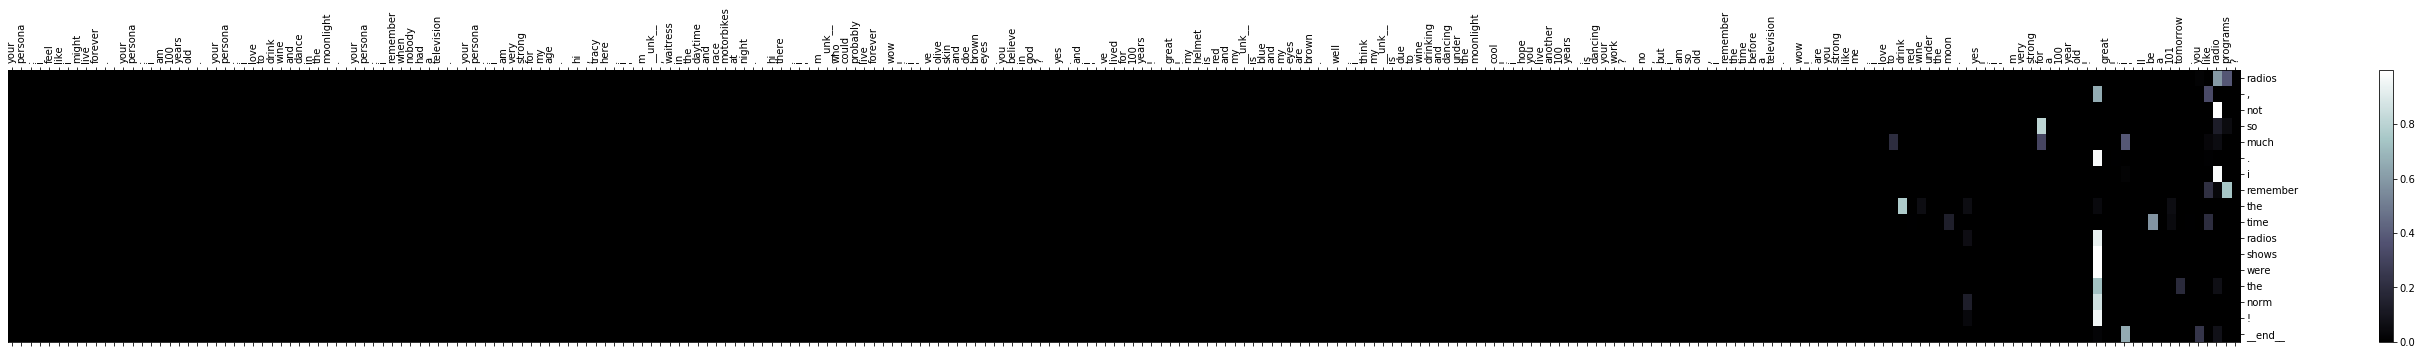

Input:
your persona : i am a stay at home dad . 
 your persona : horror movies are my favorites . 
 your persona : i spent a decade working in the human services field . 
 your persona : my father used to work for home depot . 
 hey ! how are you doing today ? 
 hi ! doing great . where are you from ? 
 i am from the south in the us . what about you ?
Target:
i live in hawaii and i work from home . __end__


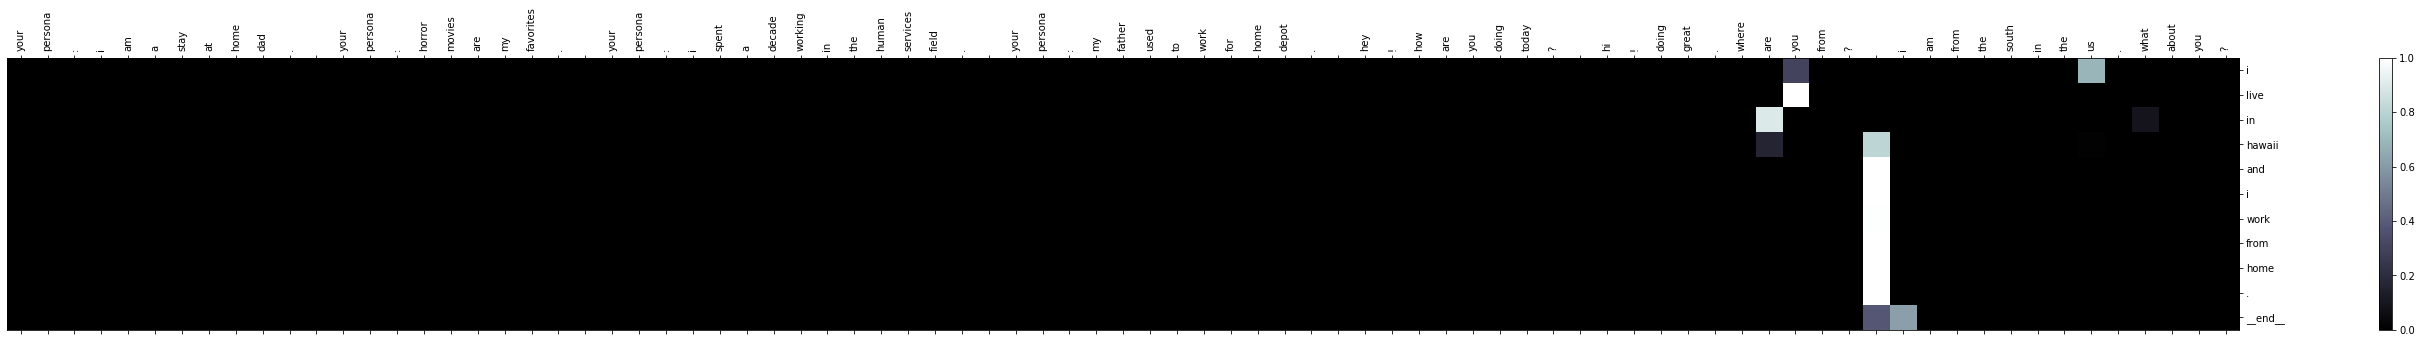

In [66]:
for i in range(5):
    print('Input:\n' + inputs[i])
    print('Target:\n' + targets[i])
    showAttention(inputs[i], targets[i], attns[i])
    

## 1.2 Encoder Transformer

In [0]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_len, emb_dim, num_layers=2, nhead=4, dropout=0, pad_idx=0, shared_lt=None):
        super().__init__()
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.token_embed = nn.Embedding(vocab_size, embed_dim, 0) # pad_idx = 0
        else:
            self.token_embed = shared_lt
        
        self.position_encoding = nn.Embedding(max_len, emb_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=2048, dropout=0.0)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, text_vec, text_vec_len):
        max_len = max(text_vec_len)
        pos_vec = torch.tensor([list(range(1, lens + 1)) + [0] * (max_len - lens) for lens in text_vec_len]).to('cuda')
        
        x = self.token_embed(text_vec) + self.position_encoding(pos_vec)

        x = self.dropout(x)
        attention_mask = text_vec.ne(self.pad_idx)
        attention_mask_1 = text_vec.eq(self.pad_idx)
        x = self.transformer(x.transpose(0,1), src_key_padding_mask=attention_mask_1).transpose(0,1)
        
        l = []
        for i in range(text_vec.size(0)): # batch size
            j = text_vec_len[i] - 1
            l.append(x[i, j, :].unsqueeze(0))  
        hidden = torch.cat(l, dim = 0).unsqueeze(0).repeat(2,1,1)

        return x, attention_mask, hidden


class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, encoder_states): # decoder_input, encoder_states
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, attention_mask, decoder_hidden = encoder_states
        
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
          
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, attention_mask, decoder_hidden = encoder_states
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log 

class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)
     
        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights      

In [0]:
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout']
                                )
        
        self.encoder = EncoderTransformer(
                                    vocab_size=self.opts['vocab_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    max_len=self.opts['max_len'],
                                    emb_dim=self.opts['embedding_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    nhead=self.opts['nhead'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = False
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./drive/My Drive/nlp4_save_model/1107_Bert_Encoder/bert3.pth')
    else:
        model_pt = torch.load('./drive/My Drive/nlp4_save_model/1107_Bert_Encoder/bert3.pth', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    best_val_loss = model_pt['best_val_loss']
    
else:
    
    opts = {}
    
    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 256
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True
    opts['max_len'] = 700
    opts['nhead'] = 4

    model = seq2seq(opts)
    model.to(current_device)
    best_val_loss = 100

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.001, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [0]:
import os 
import pickle

if not os.path.exists('/content/drive/My Drive/nlp4_save_model'):
  os.mkdir('/content/drive/My Drive/nlp4_save_model')

model_predix = '1111_Bert_Encoder'
path_root = '/content/drive/My Drive/nlp4_save_model/' + model_predix

if not os.path.exists(path_root):
    os.mkdir(path_root)

model_para = opts
    
with open(os.path.join(path_root,'options.pickle'), 'wb') as handle:
    pickle.dump(model_para, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [0]:
plot_cache = []

for epoch in range(10):
    
    model.train()
    sum_loss = 0
    sum_tokens = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        text_vecs = batch['text_vecs'].to('cuda')
        text_lens = batch['text_lens']
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs, text_lens)
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        sum_loss += loss.item()
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        loss /= num_tokens
        
        sum_tokens += num_tokens
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            avg_train_loss = sum_loss/sum_tokens
            print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))
                    
    val_loss = 0
    val_tokens = 0
    for i, batch in enumerate(valid_loader):
        model.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        text_lens = batch['text_lens']
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs, text_lens)
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
        
    avg_val_loss = val_loss/val_tokens
    #scheduler.step(avg_val_loss)
        
    print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
    
    plot_cache.append( (avg_train_loss, avg_val_loss) )
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
    
    model_path = os.path.join(path_root,'bert'+ str(epoch)+'.pth')
    torch.save({
        'best_val_loss': best_val_loss,
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
        }, model_path)

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

best_model = '/bert9.pth'
if current_device == 'cuda':
    model_pt = torch.load(path_root + best_model)
else:
    model_pt = torch.load(path_root + best_model, map_location=torch.device('cpu'))

In [0]:
plot_cache = model_pt['plot_cache']

## You present here:

In [0]:
# check pdf to see what you expected to present

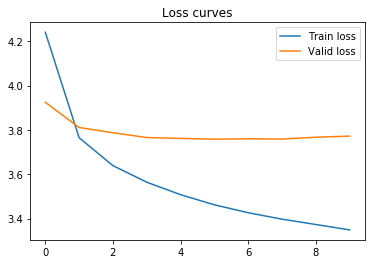

In [51]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

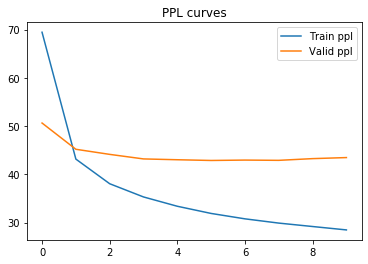

In [52]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [53]:
val_loss_min = min([i[1] for i in plot_cache])
val_ppl_min = min([2**(i[1]/numpy.log(2)) for i in plot_cache])
print('The lowest validation ppl is {}.'.format(val_ppl_min))

The lowest validation ppl is 42.86508704571175.


In [69]:
!md5sum '/content/drive/My Drive/nlp4_save_model/1111_Bert_Encoder/bert9.pth'

40e7157d50cd5cdada8a7d8dd1fb43a5  /content/drive/My Drive/nlp4_save_model/1111_Bert_Encoder/bert9.pth


# Part 2 Decoding

In [10]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

In [11]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [12]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [13]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [14]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

## 2.1 Nucleus Sampling

In [15]:
# implement nucleus sampling here.
# you must cite any code you use from other sources!

In [16]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

100%|██████████| 7801/7801 [00:01<00:00, 5219.99it/s]


In [17]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

In [18]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [19]:
num_gpus = torch.cuda.device_count()
num_gpus = 0
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./chat_model_best_22.pt')
    else:
        model_pt = torch.load('./chat_model_best_22.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    
else:
    
    opts = {}

    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 512
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True

    model = seq2seq(opts)
    model.to(current_device)

### Nucleus Sampling Function

In [20]:
def nucleus_sampling(model, batch, batch_size, para_nucleus):
    model.eval()
        
    text_vecs = batch['text_vecs'].to(current_device)

    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    encoder_output, encoder_hidden, attention_mask = encoded
        
    # 1 is __start__
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
    decoder_hidden = encoder_hidden

    # greedy decoding here        
    preds = [starts]
    scores = []
    tokens_record = []

    # track if each sample in the mini batch is finished
    # if all finished, stop predicting
    finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
    xs = starts
    _attn_w_log = []

    for ts in range(100):
        decoder_output, decoder_hidden, attn_w_log = model.decoder(xs, decoder_hidden, encoded)  # decoder_output: [batch, time, vocab]
        nucleus_scores = torch.log_softmax(decoder_output, dim=-1).view(-1)
        probs_conditional = torch.softmax(decoder_output, dim=-1).view(-1)
        nucleus_scores_sorted, indices = torch.sort(nucleus_scores, descending=True)
        probs_sorted, indices = torch.sort(probs_conditional, descending=True)
        
        #generate subset
        sum_probs_token = 0
        for ind, probs_token in enumerate(probs_sorted):
          sum_probs_token = sum_probs_token + probs_token
          num = ind + 1
          if sum_probs_token > para_nucleus:
            break
        #print('subset size:',num)
        subset = indices[:num]
        probs_new = probs_sorted[:num]/sum(probs_sorted[:num])
        scores_new = nucleus_scores_sorted[:num]
        assert len(subset)==len(probs_new)
        assert len(subset)==len(scores_new)

        #sampling with multinomial
        experiments = torch.multinomial(probs_new, 1, replacement = True)
        _preds = subset[experiments].unsqueeze(0)
        _scores = scores_new[experiments]
        
        preds.append(_preds)
        tokens_record.append(_preds.view(-1).tolist()[0])
        _attn_w_log.append(attn_w_log)
        scores.append(_scores.view(-1)*(finish_mask == 0).float())

        finish_mask += (_preds == 2).byte().view(-1)
        
        if not (torch.any(~finish_mask.bool())):
            break
        
        xs = _preds
    preds = torch.cat(preds, dim=-1)
    log_probability = 0
    for i in scores:
      log_probability += i
    #print(log_probability)
        
    return preds, log_probability, tokens_record

In [21]:
def run_sample(para_nucleus, sample_times, inputs):
  test_batch = {
    'text_vecs': torch.tensor([chat_dict.t2v(inputs)], dtype=torch.long, device=model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(inputs)], dtype=torch.long),
    'use_packed': True,
    }

  log_probability_list = []
  tokens_record_list = []
  for i in range(sample_times):
    output, log_probability, tokens_record = nucleus_sampling(model, test_batch, 1, para_nucleus)
    print(chat_dict.v2t(output[0].tolist()))
    log_probability_list.append(log_probability)
    tokens_record_list += tokens_record

  sampled_toks_unique = len(set(tokens_record_list))
  average_log_probs = 0
  for i in range(len(log_probability_list)):
    average_log_probs += log_probability_list[i]
  average_log_probs = average_log_probs/len(log_probability_list)

  print(average_log_probs)
  print(sampled_toks_unique)

  return average_log_probs, sampled_toks_unique


In [22]:
# artificial example (try removing the question mark, result will be different)
#inputs = RETOK.findall("hello , where are you from?")
inputs = RETOK.findall("your persona: i live in texas.\n hello , where are you ? ?")

#### parameter = 0.1

In [14]:
average_log_probs_1, sampled_toks_unique_1 = run_sample(para_nucleus = 0.1, sample_times = 100, inputs = inputs)

__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start__ i am from california , where are you from ? __end__
__start_

#### parameter = 0.5

In [15]:
average_log_probs_2, sampled_toks_unique_2 = run_sample(para_nucleus = 0.5, sample_times = 100, inputs = inputs)

__start__ i ' m from alabama , i live in wisconsin . __end__
__start__ i ' m from the united states . how about you ? __end__
__start__ i am from kansas , texas . how about you ? __end__
__start__ i ' m from boston . how about you ? __end__
__start__ hi ! i am from maine , texas , and you ? __end__
__start__ i ' m from florida , i live in vienna . __end__
__start__ i am from the usa , where are you from ? __end__
__start__ i am from california , i live in vienna . how about you ? __end__
__start__ i ' m from the usa . how about you ? __end__
__start__ i ' m from california , where are you from ? __end__
__start__ i ' m from california . i am from colorado . __end__
__start__ i am from kansas . how about you ? __end__
__start__ i ' m from colorado . how about you ? __end__
__start__ hi ! i am from california . i live in colorado . you ? __end__
__start__ i ' m from the usa . how about you ? __end__
__start__ i ' m from boston ma . how about you ? __end__
__start__ i am from kansas , tc 

#### parameter = 0.9

In [16]:
average_log_probs_3, sampled_toks_unique_3 = run_sample(para_nucleus = 0.9, sample_times = 100, inputs = inputs)

__start__ hey ! yes me at , how about you ? __end__
__start__ great ! i was born in va in virginia , you ? __end__
__start__ hi . . . how are you today ? __end__
__start__ i am from maine . where are you from ? __end__
__start__ hello ! i am from hawaii , where did you go ? __end__
__start__ i live in ny . where are you from ? __end__
__start__ cali here . just moved from kansas right now __end__
__start__ i am in alabama . how about you ? __end__
__start__ hi , how are you today ? i was in pa with my poodle __end__
__start__ we usually had an apartment before ? __end__
__start__ just where i live __end__
__start__ hi ! they ' re great ! i love to hike and alternative in japan . how about you ? __end__
__start__ i am traveling , had a bit of homework __end__
__start__ hello , i ' m pretty really great . how about you ? __end__
__start__ where are you from ? i am from wisconsin . __end__
__start__ i am originally from boston . __end__
__start__ i am from california . i like to talk abou

## You present here:

In [0]:
# check pdf to see what you expected to present

#### average log-probability

In [0]:
import matplotlib.pyplot as plt

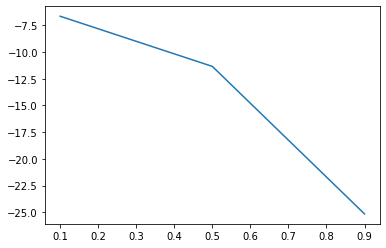

In [19]:
parameters = [0.1, 0.5, 0.9]
avg_log_probs = [average_log_probs_1, average_log_probs_2, average_log_probs_3]
fig = plt.plot(parameters, avg_log_probs)

#### number of unique tokens

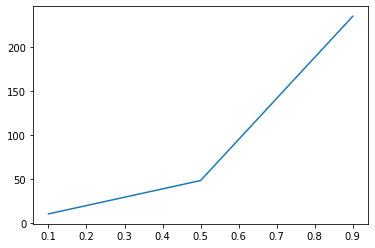

In [20]:
parameters = [0.1, 0.5, 0.9]
avg_log_probs = [sampled_toks_unique_1, sampled_toks_unique_2, sampled_toks_unique_3]
fig = plt.plot(parameters, avg_log_probs)

## 2.2 N-Gram blocking

In [23]:
import math
from operator import attrgetter

class _HypothesisTail(object):
    """Hold some bookkeeping about a hypothesis."""

    # use slots because we don't want dynamic attributes here
    __slots__ = ['timestep', 'hypid', 'score', 'tokenid']

    def __init__(self, timestep, hypid, score, tokenid):
        self.timestep = timestep
        self.hypid = hypid
        self.score = score
        self.tokenid = tokenid

class Beam(object):
    """
    This class serves to keep info about partial hypothesis and perform the beam step
    """
    
    def __init__(
        self,
        beam_size,
        padding_token=0,
        bos_token=1,
        eos_token=2,
        min_length=3,
        min_n_best=3,
        device='cpu',
        # for iterbeam below
        similarity_metric='hamming',
        similarity_threshold=0,
    ):
        
        self.beam_size = beam_size
        self.min_length = min_length
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device
        # recent score for each hypo in the beam
        self.scores = None
        # self.scores values per each time step
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        # backtracking id to hypothesis at previous time step
        self.bookkeep = []
        # output tokens at each time step
        self.outputs = [
            torch.Tensor(self.beam_size).long().fill_(self.bos).to(self.device)
        ]
        # keeps tuples (score, time_step, hyp_id)
        self.finished = []
        self.eos_top = False
        self.eos_top_ts = None
        self.n_best_counter = 0
        self.min_n_best = min_n_best
        self.partial_hyps = [[self.bos] for i in range(beam_size)]

        # iterbeam related below
        self.history_hyps = []
        self.similarity_metric = similarity_metric
        self.similarity_threshold = similarity_threshold
        self.banned_tokens = set()
        
    def get_output_from_current_step(self):
        """Get the output at the current step."""
        return self.outputs[-1]

    def get_backtrack_from_current_step(self):
        """Get the backtrack at the current step."""
        return self.bookkeep[-1]
    
    ##################### ITER-BEAM BLOCKING PART START #####################
    
    def hamming_distance(self, t1, t2):
        dist = 0
        for tok1, tok2 in zip(t1,t2):
            if tok1 != tok2:
                dist += 1
        return dist
    
    def edit_distance(self, t1, t2):
        import editdistance
        dist = editdistance.eval(t1, t2)
        return dist
                
    def similarity_check(self, active_hyp, previous_hyps, metric='hamming', threshold=0):
        banned_tokens = []
        active_len = len(active_hyp)
        for observed_hyp, _banned_tokens in previous_hyps.items():
            if len(observed_hyp) != active_len:
                continue
            if metric == 'hamming':
                dist = self.hamming_distance(observed_hyp, active_hyp)
            if metric == 'edit':
                dist = self.edit_distance(observed_hyp, active_hyp)
            if dist <= threshold:
                banned_tokens.extend(_banned_tokens)
                    
        return list(set(banned_tokens))
    
    ##################### ITER-BEAM BLOCKING PART END ########################
    




    def select_paths(self, logprobs, prior_scores, previous_hyps, len_ngram=3):
        """Select the next vocabulary item in these beams."""



        # beam search actually looks over all hypotheses together so we flatten
        beam_scores = logprobs + prior_scores.unsqueeze(1).expand_as(logprobs)
        
        # block ngrams repeats part

        current_length = len(self.all_scores)
        # print(current_length)
        # print(beam_scores)
        for hyp_id in range(beam_scores.size(0)):
            active_hyp = self.partial_hyps[hyp_id]
            # print(active_hyp)
            banned = []
            # print(len_ngram)
            if len_ngram !=1:
                  current_hist = active_hyp[-(len_ngram-1):]
                  # print(current_hist)
                  for ngram in zip(*[active_hyp[i:] for i in range(len_ngram)]):
                          if ngram[:-1] == current_hist:
                            banned.append(ngram[-1])
                  # print(banned)
                  beam_scores[hyp_id, banned] = -10e15
            else:
                for ngram in active_hyp:
                        banned.append(ngram)
                beam_scores[hyp_id, banned] = -10e15



        # # iterbeam blocking part
        # current_length = len(self.all_scores)
        # if len(previous_hyps) > 0 and current_length > 0:
        #     for hyp_id in range(beam_scores.size(0)):
        #         active_hyp = tuple(self.partial_hyps[hyp_id])
        #         banned_tokens = self.similarity_check(active_hyp, previous_hyps, metric=self.similarity_metric, threshold=self.similarity_threshold)
        #         if len(banned_tokens) > 0:
        #             beam_scores[:, banned_tokens] = -10e5
            


        flat_beam_scores = beam_scores.view(-1)
        best_scores, best_idxs = torch.topk(flat_beam_scores, self.beam_size, dim=-1)
        voc_size = logprobs.size(-1)

        # get the backtracking hypothesis id as a multiple of full voc_sizes
        hyp_ids = best_idxs / voc_size
        # get the actual word id from residual of the same division
        tok_ids = best_idxs % voc_size
        
        return (hyp_ids, tok_ids, best_scores)
    

    def advance(self, logprobs, previous_hyps,len_ngram=3):
        """Advance the beam one step."""
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(logprobs.size(0)):
                logprobs[hyp_id][self.eos] = -10e5

        if self.scores is None:
            logprobs = logprobs[0:1]  # we use only the first hyp now, since they are all same
            self.scores = torch.zeros(1).type_as(logprobs).to(logprobs.device)
            
        hyp_ids, tok_ids, self.scores = self.select_paths(logprobs, self.scores, previous_hyps,len_ngram=len_ngram)
        
        # clone scores here to avoid referencing penalized EOS in the future!
        self.all_scores.append(self.scores.clone())

        self.outputs.append(tok_ids)
        self.bookkeep.append(hyp_ids)
        self.partial_hyps = [
            self.partial_hyps[hyp_ids[i]] + [tok_ids[i].item()]
            for i in range(self.beam_size)
        ]
        self.history_hyps.extend(self.partial_hyps)

        #  check new hypos for eos label, if we have some, add to finished
        for hypid in range(self.beam_size):
            if self.outputs[-1][hypid] == self.eos:
                self.scores[hypid] = -10e5
                #  this is finished hypo, adding to finished
                eostail = _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=hypid,
                    score=self.all_scores[-1][hypid],
                    tokenid=self.eos,
                )
                self.finished.append(eostail)
                self.n_best_counter += 1

        if self.outputs[-1][0] == self.eos:
            self.eos_top = True
            if self.eos_top_ts is None:
                self.eos_top_ts = len(self.outputs) - 1
    
    def is_done(self):
        """Return whether beam search is complete."""
        return self.eos_top and self.n_best_counter >= self.min_n_best

    def get_top_hyp(self):
        """
        Get single best hypothesis.
        :return: hypothesis sequence and the final score
        """
        return self._get_rescored_finished(n_best=1)[0]

    def _get_hyp_from_finished(self, hypothesis_tail):
        """
        Extract hypothesis ending with EOS at timestep with hyp_id.
        :param timestep:
            timestep with range up to len(self.outputs) - 1
        :param hyp_id:
            id with range up to beam_size - 1
        :return:
            hypothesis sequence
        """
        hyp_idx = []
        endback = hypothesis_tail.hypid
        for i in range(hypothesis_tail.timestep, -1, -1):
            hyp_idx.append(
                _HypothesisTail(
                    timestep=i,
                    hypid=endback,
                    score=self.all_scores[i][endback],
                    tokenid=self.outputs[i][endback],
                )
            )
            endback = self.bookkeep[i - 1][endback]

        return hyp_idx

    def _get_pretty_hypothesis(self, list_of_hypotails):
        """Return hypothesis as a tensor of token ids."""
        return torch.stack([ht.tokenid for ht in reversed(list_of_hypotails)])

    def _get_rescored_finished(self, n_best=None, add_length_penalty=False):
        """
        Return finished hypotheses according to adjusted scores.
        Score adjustment is done according to the Google NMT paper, which
        penalizes long utterances.
        :param n_best:
            number of finalized hypotheses to return
        :return:
            list of (tokens, score) pairs, in sorted order, where:
              - tokens is a tensor of token ids
              - score is the adjusted log probability of the entire utterance
        """
        # if we never actually finished, force one
        if not self.finished:
            self.finished.append(
                _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=0,
                    score=self.all_scores[-1][0],
                    tokenid=self.eos,
                )
            )

        rescored_finished = []
        for finished_item in self.finished:
            if add_length_penalty:
                current_length = finished_item.timestep + 1
                # these weights are from Google NMT paper
                length_penalty = math.pow((1 + current_length) / 6, 0.65)
            else:
                length_penalty = 1
            rescored_finished.append(
                _HypothesisTail(
                    timestep=finished_item.timestep,
                    hypid=finished_item.hypid,
                    score=finished_item.score / length_penalty,
                    tokenid=finished_item.tokenid,
                )
            )

        # Note: beam size is almost always pretty small, so sorting is cheap enough
        srted = sorted(rescored_finished, key=attrgetter('score'), reverse=True)

        if n_best is not None:
            srted = srted[:n_best]

        return [
            (self._get_pretty_hypothesis(self._get_hyp_from_finished(hyp)), hyp.score)
            for hyp in srted
        ]

In [24]:
def reorder_encoder_states(encoder_states, indices):
        """Reorder encoder states according to a new set of indices."""
        enc_out, hidden, attention_mask = encoder_states

        # LSTM or GRU/RNN hidden state?
        if isinstance(hidden, torch.Tensor):
            hid, cell = hidden, None
        else:
            hid, cell = hidden

        if not torch.is_tensor(indices):
            # cast indices to a tensor if needed
            indices = torch.LongTensor(indices).to(hid.device)

        hid = hid.index_select(1, indices)
        if cell is None:
            hidden = hid
        else:
            cell = cell.index_select(1, indices)
            hidden = (hid, cell)

        enc_out = enc_out.index_select(0, indices)
        attention_mask = attention_mask.index_select(0, indices)

        return enc_out, hidden, attention_mask
    
    
def reorder_decoder_incremental_state(incremental_state, inds):
    if torch.is_tensor(incremental_state):
        # gru or lstm
        return torch.index_select(incremental_state, 1, inds).contiguous()
    elif isinstance(incremental_state, tuple):
        return tuple(
            self.reorder_decoder_incremental_state(x, inds)
            for x in incremental_state)

def get_nbest_list_from_beam(beam, dictionary, n_best=None, add_length_penalty=False):
    if n_best is None:
        n_best = beam.min_n_best
    nbest_list = beam._get_rescored_finished(n_best=n_best, add_length_penalty=add_length_penalty)
    
    nbest_list_text = [(dictionary.v2t(i[0].cpu().tolist()), i[1].item()) for i in nbest_list]
    
    return nbest_list_text

In [25]:
def generate_with_beam(beam_size, min_n_best, model, batch, batch_size, previous_hyps=None, similarity_metric='hamming', similarity_threshold=0, verbose=False, len_ngram=3):
    """
    This function takes a model, batch, beam settings and performs decoding with a beam
    """
    beams = [Beam(beam_size, min_n_best=min_n_best, eos_token=chat_dict.word2ind['__end__'], padding_token=chat_dict.word2ind['__null__'], bos_token=chat_dict.word2ind['__start__'], device=current_device, similarity_metric=similarity_metric, similarity_threshold=similarity_threshold) for _ in range(batch_size)]
    repeated_inds = torch.arange(batch_size).to(current_device).unsqueeze(1).repeat(1, beam_size).view(-1)
    #print(batch_size)
    text_vecs = batch['text_vecs'].to(current_device)
#     print( batch['text_lens'])

    encoder_states = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    model.eval()
    
    encoder_states = reorder_encoder_states(encoder_states, repeated_inds)  # no actual reordering here, but repeating beam size times each sample in the minibatch
    encoder_output, encoder_hidden, attention_mask = encoder_states
    
    incr_state = encoder_hidden  # we init decoder hidden with last encoder_hidden
    
    # 1 is a start token id
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size*beam_size, 1).long()  # expand to batch_size * beam_size
    decoder_input = starts
    
    with torch.no_grad():
        for ts in range(100):
            if all((b.is_done() for b in beams)):
                break
            score, incr_state, attn_w_log = model.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:, :]  # take last time step and eliminate the dimension
            score = score.view(batch_size, beam_size, -1)
            score = torch.log_softmax(score, dim=-1)
         
            for i, b in enumerate(beams):
                if not b.is_done():
                    # make mock previous_hyps if not used #
                    if previous_hyps is None:
                        previous_hyps = [{} for i in range(batch_size)]

                    b.advance(score[i], previous_hyps[i],len_ngram=len_ngram)

            incr_state_inds = torch.cat([beam_size * i + b.get_backtrack_from_current_step() for i, b in enumerate(beams)])
            incr_state = reorder_decoder_incremental_state(incr_state, incr_state_inds)
            selection = torch.cat([b.get_output_from_current_step() for b in beams]).unsqueeze(-1)
            decoder_input = selection

    beam_preds_scores = [list(b.get_top_hyp()) for b in beams]

    if verbose:
        for bi in range(batch_size):
            #print(f'batch {bi}')
            for i in get_nbest_list_from_beam(beams[bi], chat_dict, n_best=min_n_best):
                print(i)
    
    return beam_preds_scores, beams

## You present here:

In [0]:
# check pdf to see what you expected to present

#### Length of ngram equals *1*

In [25]:
batch_size = 1
beam_size = 20
beam_n_best = 10
len_ngram = 1

valid_loader_single = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=batch_size)

valid_sample = next(iter(valid_loader_single))


for i,valid_sample in enumerate(valid_loader_single):
      if i == 56:
        print(valid_sample)
        print(chat_dict.v2t(list(valid_sample['text_vecs'].numpy()[0])))
        beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True,len_ngram=len_ngram)

{'text_vecs': tensor([[    7,    10,    12,     5,    31,    14,   294,   931,    23,   323,
            24,    19, 10432,     4,    11,     7,    10,    12,     5,    28,
            83,  1108,    33,    15,   543,     4,    11,     7,    10,    12,
             5,    16,    26,  1873,   144,   141,     4,    11,     7,    10,
            12,     5,   253,    21,     5,   388,    72,  1274,     4,    11,
            58,    13,    34,    25,     6,    65,    82,     9,    11,    41,
            20,     6,    20,  5525,    37,  2874,     3,    11,    68,     4,
             5,    16,    26,   216,    97,  1771,   189,    37,    15,   117,
             4,    11,    22,    93,    21,    88,     4,     5,    21,   931,
            23,   584,    49,    20,    11,   313,     4,     5,   185,    14,
            74,     8,   328,   927,    24,     8,   261,  1499,   398,    33,
            36,    18,  2307,     4,    11,   134,    20,   479,    21,    22,
             6,   388,    72,  1274,  

#### Length of ngram equals 2

In [26]:
batch_size = 1
beam_size = 20
beam_n_best = 10
len_ngram = 2

valid_loader_single = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=batch_size)

valid_sample = next(iter(valid_loader_single))


for i,valid_sample in enumerate(valid_loader_single):
      if i == 56:
        print(valid_sample)
        print(chat_dict.v2t(list(valid_sample['text_vecs'].numpy()[0])))
        beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True,len_ngram=len_ngram)

{'text_vecs': tensor([[    7,    10,    12,     5,    31,    14,   294,   931,    23,   323,
            24,    19, 10432,     4,    11,     7,    10,    12,     5,    28,
            83,  1108,    33,    15,   543,     4,    11,     7,    10,    12,
             5,    16,    26,  1873,   144,   141,     4,    11,     7,    10,
            12,     5,   253,    21,     5,   388,    72,  1274,     4,    11,
            58,    13,    34,    25,     6,    65,    82,     9,    11,    41,
            20,     6,    20,  5525,    37,  2874,     3,    11,    68,     4,
             5,    16,    26,   216,    97,  1771,   189,    37,    15,   117,
             4,    11,    22,    93,    21,    88,     4,     5,    21,   931,
            23,   584,    49,    20,    11,   313,     4,     5,   185,    14,
            74,     8,   328,   927,    24,     8,   261,  1499,   398,    33,
            36,    18,  2307,     4,    11,   134,    20,   479,    21,    22,
             6,   388,    72,  1274,  

#### Length of ngram equals 3

In [27]:
batch_size = 1
beam_size = 20
beam_n_best = 10
len_ngram = 3

valid_loader_single = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=batch_size)

valid_sample = next(iter(valid_loader_single))


for i,valid_sample in enumerate(valid_loader_single):
    if i == 56:
        print(valid_sample)
        print(chat_dict.v2t(list(valid_sample['text_vecs'].numpy()[0])))
        beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True,len_ngram=len_ngram)

{'text_vecs': tensor([[    7,    10,    12,     5,    31,    14,   294,   931,    23,   323,
            24,    19, 10432,     4,    11,     7,    10,    12,     5,    28,
            83,  1108,    33,    15,   543,     4,    11,     7,    10,    12,
             5,    16,    26,  1873,   144,   141,     4,    11,     7,    10,
            12,     5,   253,    21,     5,   388,    72,  1274,     4,    11,
            58,    13,    34,    25,     6,    65,    82,     9,    11,    41,
            20,     6,    20,  5525,    37,  2874,     3,    11,    68,     4,
             5,    16,    26,   216,    97,  1771,   189,    37,    15,   117,
             4,    11,    22,    93,    21,    88,     4,     5,    21,   931,
            23,   584,    49,    20,    11,   313,     4,     5,   185,    14,
            74,     8,   328,   927,    24,     8,   261,  1499,   398,    33,
            36,    18,  2307,     4,    11,   134,    20,   479,    21,    22,
             6,   388,    72,  1274,  

# Part 3 Interactive chat

In [267]:
# implement logic for interactive chat here
# the easiest is to just use python input functionality

In [268]:
from ipywidgets import widgets

import tkinter as  tk
from tkinter import ttk  
win = tk.Toplevel()
win.wm_title("Window")

label = tk.Label(win, text="User input")
label.grid(row=0, column=0)

button = ttk.Button(win, text="Done", command=win.destroy)
button.grid(row=1, column=0)



In [269]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display



In [270]:
persona_text = 'your persona : i am a vegan and i love hummus . \n your persona : i love rollercoasters and sky diving . \n your persona : i do like watching cooking shows . \n your persona : i am not a good swimmer at all .' 
log_history = persona_text

In [271]:
def interact_function(x,log_history):
    print(log_history)
    print(x)
    return 

In [272]:
button = widgets.Button(description="Run decoding!")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        log_history.value += '\n'
        # append the input dialog to the sequence
        log_history.value += x.value
        # # append the new line mark
        log_history.value += '\n'
        
        # process the log_history
        persona_text_processed = log_history.value.split(' ')
        persona_vector = chat_dict.t2v(persona_text_processed)
        valid_sample = {}
        valid_sample['text_vecs'] = torch.tensor([persona_vector])
        valid_sample['text_lens'] = [len(persona_vector)]
        valid_sample['use_packed'] = True
        
        # conduct beam search
        batch_size = 1
        beam_size = 20
        beam_n_best = 20
        len_ngram = 3
        
        beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True,len_ngram=len_ngram)
#     print(get_nbest_list_from_beam(beams[0], chat_dict, n_best=beam_n_best))

    # get the fifth answer
        tmpt = get_nbest_list_from_beam(beams[0], chat_dict, n_best=beam_n_best)[10][0]
#     print('tmpt')
#     print('\n')
#     print(tmpt.split('__')[2])

    # append the output to the log history
        log_history.value += tmpt.split('__')[2]
        x.value = ''
        print(tmpt.split('__')[2])

In [273]:
log_history = widgets.Textarea(
    value=persona_text,
    placeholder='Type something',
    description='Log_history:',
    disabled=False
)
x = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='Input:',
        disabled=False
    )

## You present here:

In [274]:
# check pdf to see what you expected to present

In [275]:
interact_manual(interact_function,x = x,log_history = log_history)
display(button, output)
button.on_click(on_button_clicked)

interactive(children=(Textarea(value='', description='Input:', placeholder='Type something'), Textarea(value='…

Button(description='Run decoding!', style=ButtonStyle())

Output()

#### A conversation generated by our model

your persona : i am a vegan and i love hummus . 

your persona : i love rollercoasters and sky diving . 

your persona : i do like watching cooking shows . 

your persona : i am not a good swimmer at all .' 

Hi, how are you?

hi , i ' m doing great . how are you ? 

I am really great! I played tennis this afternoon. It makes tired but happy. Do you like doing any sports?

hi , i ' m good . i just got back from the gym .

Sounds good. I love playing tennis. I feel excited about it. I forget all my troubles when playing tennis. What about you? 

i just got back from the gym . what do you do for fun ? 

I like cooking. But I am not a cook. I am a student, living in New York now.

i don ' t have a job but i ' m not much into sports . what do you do ? 
